# IMPORT

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from importlib import reload
import random_graph, pdmm, pdmm_median

reload(random_graph)
reload(pdmm)
reload(pdmm_median)

from random_graph import *
from pdmm import *
from pdmm_median import *
from rho_pdmm import *
from gossip import *
from drop import *

### Generate Graph

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Graph parameters
a = 100                             # Field size
n = 101                             # Number of agents
r = a * np.sqrt(2 * np.log(n)/n)   # Communication range
r = 20
#159 20 too many edges
# Generate agent positions
field_range = np.array([[0, a], [0, a]])
sensor_positions = np.array([
    np.random.uniform(field_range[0, 0], field_range[0, 1], n),
    np.random.uniform(field_range[1, 0], field_range[1, 1], n)
])

# THIS IS NOT THE ADJACENCY MATRIX, IN THIS PROBLEM IT IS EQUIVALENT TO THE INCIDENCE MATRIX
# Calculate adjacency matrix based on communication range
adjacency_matrix = calculate_adjacency_matrix(sensor_positions, r)

Plot graph and check connectivity

The communication range is: 20.00
The graph is connected: False


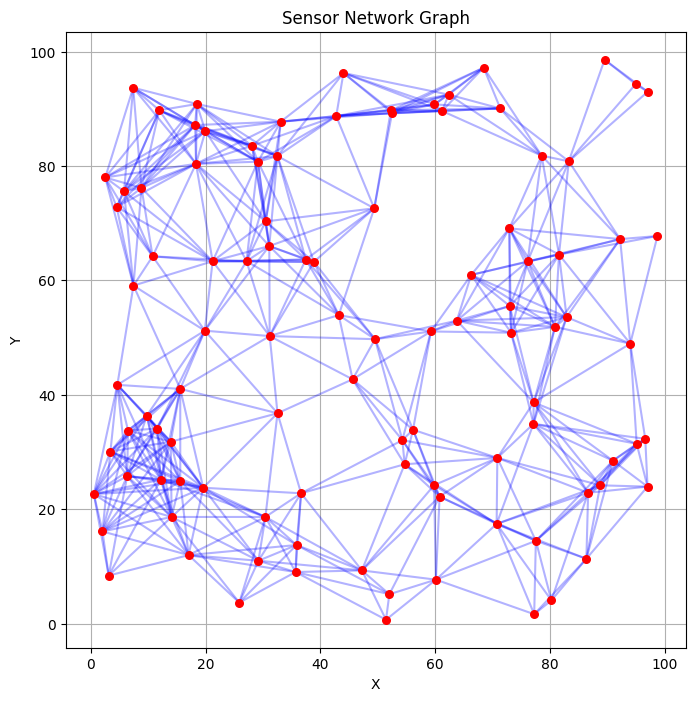

In [3]:
print(f"The communication range is: {r:.2f}")
print(f"The graph is connected: {is_connected(adjacency_matrix)}") # Is connected is not working
plot_graph(sensor_positions, adjacency_matrix)

### Randomized Gossip


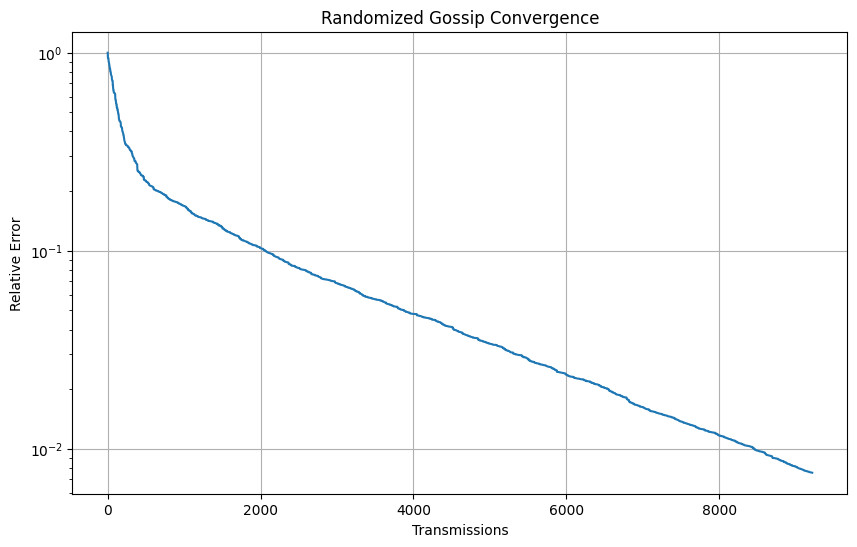

True average: 22.9230
Final average across agents: 22.9230
Min agent value: 22.8156, Max agent value: 23.0471
Final relative error: 7.5693e-03


In [14]:

sensor_values = np.random.randn(n) * 10 + 25
values,errors,time = gossip_step(sensor_values, adjacency_matrix, max_ticks=10000)

plt.figure(figsize=(10, 6))
plt.semilogy(range(len(errors)), errors)
plt.xlabel('Transmissions')
plt.ylabel('Relative Error')
plt.title(f'Randomized Gossip Convergence')
plt.grid(True)
plt.show()
print(f"True average: {np.mean(sensor_values):.4f}")
print(f"Final average across agents: {np.mean(values):.4f}")
print(f"Min agent value: {np.min(values):.4f}, Max agent value: {np.max(values):.4f}")
print(f"Final relative error: {errors[-1]:.4e}")

### Run Synchronous PDMM

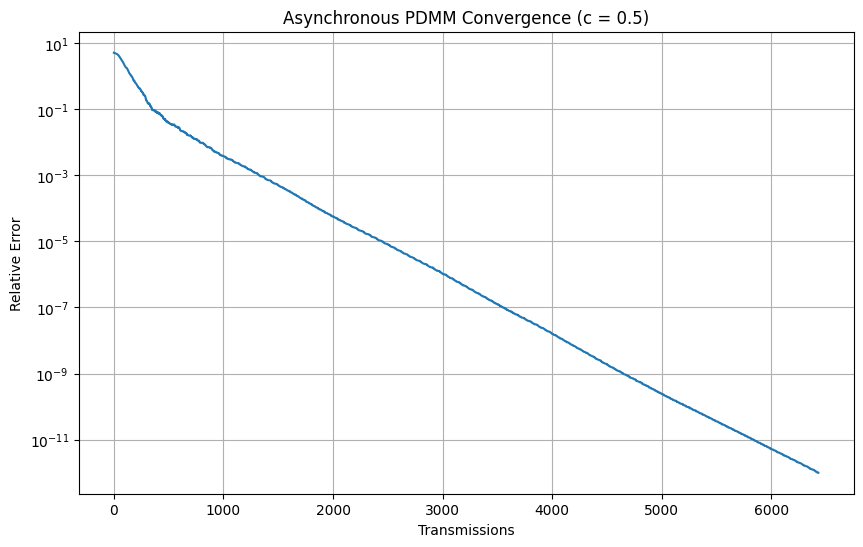

True average: 49.3639
Final average across agents: 49.3639
Min agent value: 49.3639, Max agent value: 49.3639
Final relative error: 9.9623e-13


In [ ]:
# PDMM parameters
max_transmissions = 1e6             # Max PDMM iterations
rho = 0.5                           # Penalty parameter (c)
tolerance = 1e-12                   # Convergence tolerance
sensor_values = np.random.randn(n) * 10 + 25

errors, values, n_transmissions = pdmm_sync(sensor_values, adjacency_matrix, rho, max_transmissions, tolerance)

plt.figure(figsize=(10, 6))
plt.semilogy(range(len(errors)), errors)
plt.xlabel('Transmissions')
plt.ylabel('Relative Error')
plt.title(f'Asynchronous PDMM Convergence (c = {rho})')
plt.grid(True)
plt.show()
print(f"True average: {np.mean(sensor_values):.4f}")
print(f"Final average across agents: {np.mean(values):.4f}")
print(f"Min agent value: {np.min(values):.4f}, Max agent value: {np.max(values):.4f}")
print(f"Final relative error: {errors[-1]:.4e}")

Compare the effect of C values - this runs too long

In [ ]:
# PDMM parameters
max_transmissions = 1e6             # Max PDMM transmissions
rhos = np.linspace(0.01, 1, 100)    # Penalty parameters (c)
tolerance = 1e-12                   # Convergence tolerance

sensor_values = np.random.randn(n) * 10 + 25     # Generate random sensor values
transmissions = np.ones(len(rhos)) * max_transmissions  # Initialize transmission counts
for i, rho in enumerate(rhos):
    errors, values, n_transmissions = pdmm_sync(sensor_values, adjacency_matrix, rho, max_transmissions, tolerance)
    if errors[-1] < tolerance:
        transmissions[i] = n_transmissions

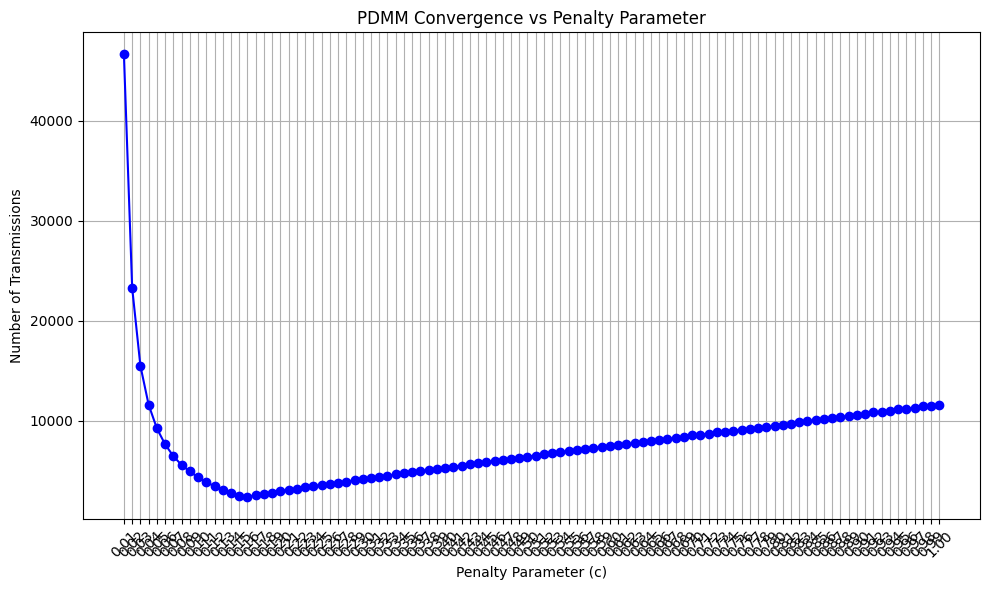

In [6]:
# Plot convergence for different rho values
plt.figure(figsize=(10, 6))
plt.plot(rhos, transmissions, marker='o', linestyle='-', color='b')
plt.xlabel('Penalty Parameter (c)')
plt.ylabel('Number of Transmissions')
plt.title('PDMM Convergence vs Penalty Parameter')
plt.grid(True)
plt.xticks(rhos, rotation=45)
plt.yticks()  # Show y-axis ticks
plt.tight_layout()
plt.show()

### Run Asynchronous PDMM

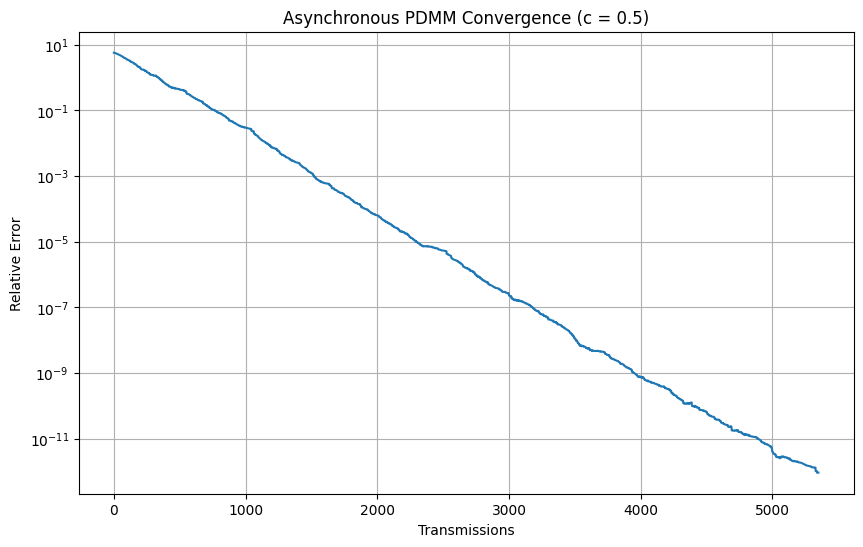

True average: 51.5419
Final average across agents: 51.5419
Min agent value: 51.5419, Max agent value: 51.5419
Final relative error: 9.2248e-13


In [ ]:
# PDMM parameters
max_transmissions = 1e6             # Max PDMM iterations
rho = 0.5                           # Penalty parameter (c)
tolerance = 1e-12                   # Convergence tolerance

sensor_values = np.random.randn(n) * 10 + 25
errors, values, n_transmissions = pdmm_async(sensor_values, adjacency_matrix, rho, max_transmissions, tolerance)

plt.figure(figsize=(10, 6))
plt.semilogy(range(len(errors)), errors)
plt.xlabel('Transmissions')
plt.ylabel('Relative Error')
plt.title(f'Asynchronous PDMM Convergence (c = {rho})')
plt.grid(True)
plt.show()
print(f"True average: {np.mean(sensor_values):.4f}")
print(f"Final average across agents: {np.mean(values):.4f}")
print(f"Min agent value: {np.min(values):.4f}, Max agent value: {np.max(values):.4f}")
print(f"Final relative error: {errors[-1]:.4e}")

## Median PDMM

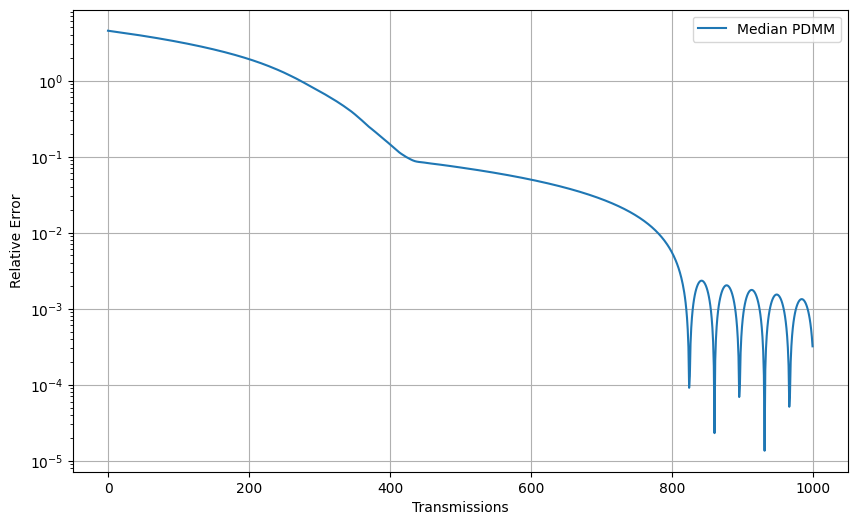

In [ ]:
max_transmissions = 1e6             
rho = 0.5                          
tolerance = 1e-12                   
sensor_values = np.random.randn(n) * 10 + 25

errors_async, x = pdmm_median(sensor_values, adjacency_matrix, rho,  max_transmissions, tolerance)

plt.figure(figsize=(10, 6))
plt.semilogy(range(len(errors_async)), errors_async, label='Median PDMM')
plt.xlabel('Transmissions')
plt.ylabel('Relative Error')
plt.legend()
plt.grid(True)
plt.show()

# COMPARISON

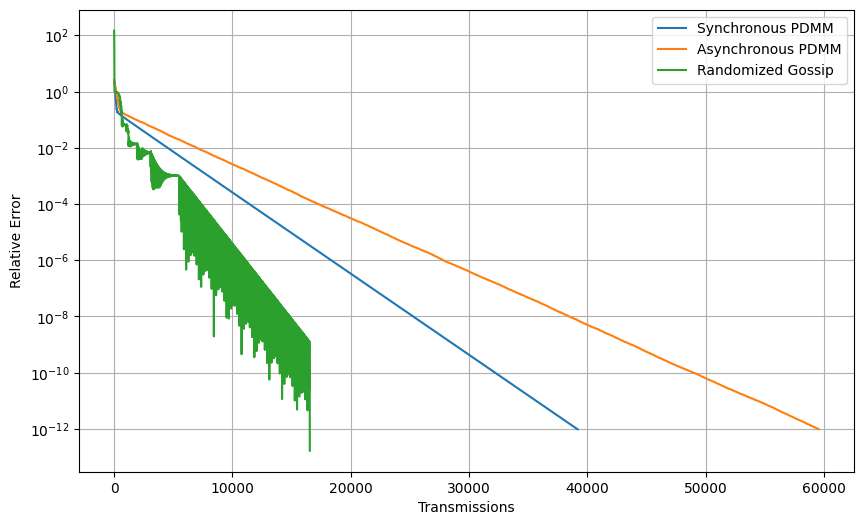

In [16]:
# PDMM parameters
max_transmissions = 1e6             # Max PDMM iterations
rho = 0.1                           # Penalty parameter (c)
tolerance = 1e-12                   # Convergence tolerance
sensor_values = np.random.randn(n) * 10 + 25

errors_sync, values_sync, n_transmissions_sync = pdmm_sync(sensor_values, adjacency_matrix, rho, max_transmissions, tolerance)
errors_async, values_async, n_transmissions_async = pdmm_async(sensor_values, adjacency_matrix, rho, max_transmissions, tolerance)
values, errors, time = gossip_step(sensor_values, adjacency_matrix, max_ticks=10000)
errors, x = pdmm_median(sensor_values, adjacency_matrix, rho,  max_transmissions, tolerance)
plt.figure(figsize=(10, 6))
plt.semilogy(range(len(errors_sync)), errors_sync, label='Synchronous PDMM')
plt.semilogy(range(len(errors_async)), errors_async, label='Asynchronous PDMM')
plt.semilogy(range(len(errors[:len(errors_async)])), errors[:len(errors_async)], label='Randomized Gossip')
plt.xlabel('Transmissions')
plt.ylabel('Relative Error')
plt.legend()
plt.grid(True)
plt.show()

### Different $\rho$


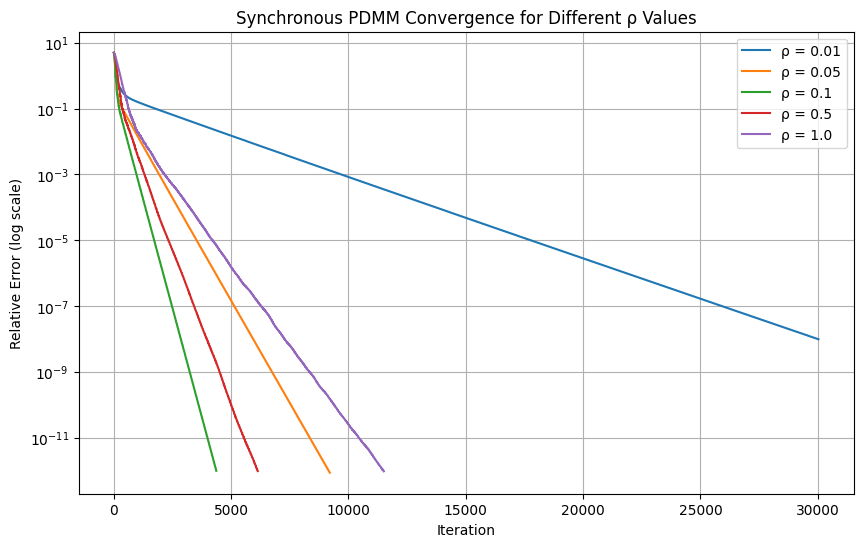

In [10]:
best_rho, results = rho_search_pdmm_sync(adjacency_matrix, sensor_values)
plt.figure(figsize=(10, 6))
for rho_val, errors in results.items():
    plt.semilogy(range(len(errors)), errors, label=f"ρ = {rho_val}")
plt.xlabel('Iteration')
plt.ylabel('Relative Error (log scale)')
plt.title('Synchronous PDMM Convergence for Different ρ Values')
plt.legend()
plt.grid(True)
plt.show()


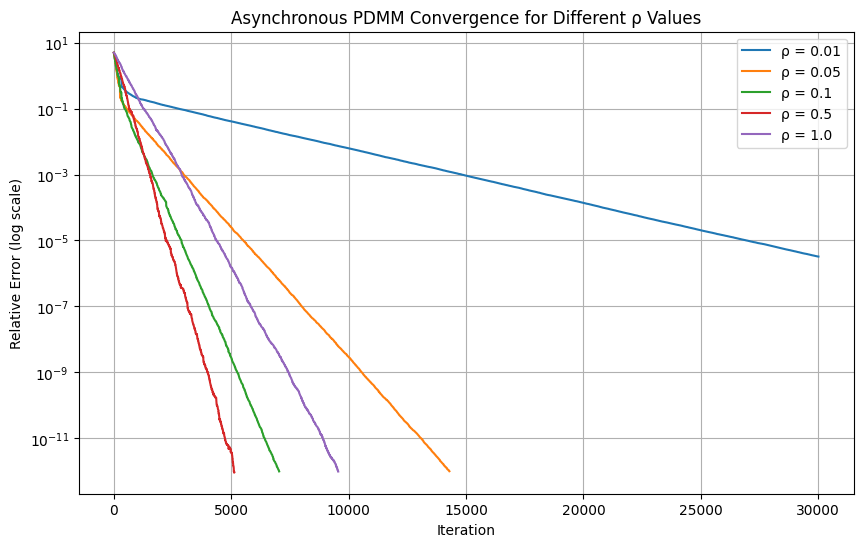

In [11]:
best_rho, results = rho_search_pdmm_async(adjacency_matrix, sensor_values)
plt.figure(figsize=(10, 6))
for rho_val, errors in results.items():
    plt.semilogy(range(len(errors)), errors, label=f"ρ = {rho_val}")
plt.xlabel('Iteration')
plt.ylabel('Relative Error (log scale)')
plt.title('Asynchronous PDMM Convergence for Different ρ Values')
plt.legend()
plt.grid(True)
plt.show()


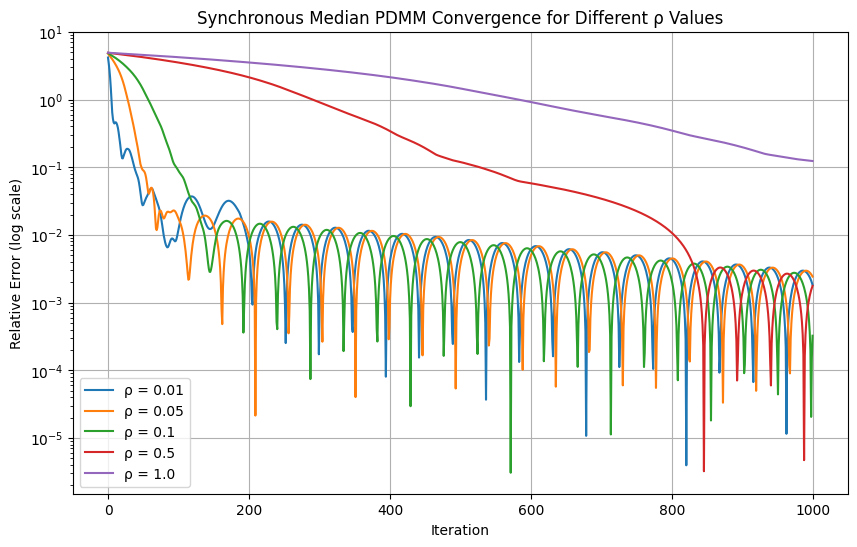

In [12]:
best_rho, results = rho_search_pdmm_median(adjacency_matrix, sensor_values)
plt.figure(figsize=(10, 6))
for rho_val, errors in results.items():
    plt.semilogy(range(len(errors)), errors, label=f"ρ = {rho_val}")
plt.xlabel('Iteration')
plt.ylabel('Relative Error (log scale)')
plt.title('Synchronous Median PDMM Convergence for Different ρ Values')
plt.legend()
plt.grid(True)
plt.show()


### Transmission Loss


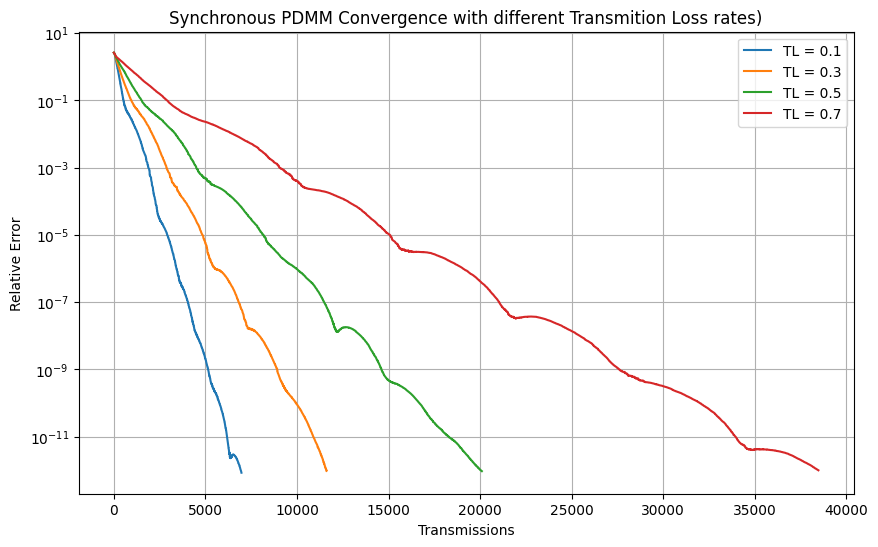

True average: 26.0788
Final average across agents: 26.0788
Min agent value: 26.0788, Max agent value: 26.0788
Final relative error: 9.9741e-13


In [17]:
# PDMM parameters
max_transmissions = 1e6             # Max PDMM iterations
rho = 0.5                           # Penalty parameter (c)
tolerance = 1e-12                   # Convergence tolerance
sensor_values = np.random.randn(n) * 10 + 25


transmissions = [0.1,0.3,0.5,0.7]
plt.figure(figsize=(10, 6))
for i in range(len(transmissions)):
    errors, values, n_transmissions = pdmm_sync(sensor_values, adjacency_matrix, rho, max_transmissions, tolerance,transmissions[i])
    plt.semilogy(range(len(errors)), errors, label=f"TL = {transmissions[i]}")

plt.xlabel('Transmissions')
plt.ylabel('Relative Error')
plt.title(f'Synchronous PDMM Convergence with different Transmition Loss rates)')
plt.grid(True)
plt.legend()
plt.show()
print(f"True average: {np.mean(sensor_values):.4f}")
print(f"Final average across agents: {np.mean(values):.4f}")
print(f"Min agent value: {np.min(values):.4f}, Max agent value: {np.max(values):.4f}")
print(f"Final relative error: {errors[-1]:.4e}")

## 

## Node drop 


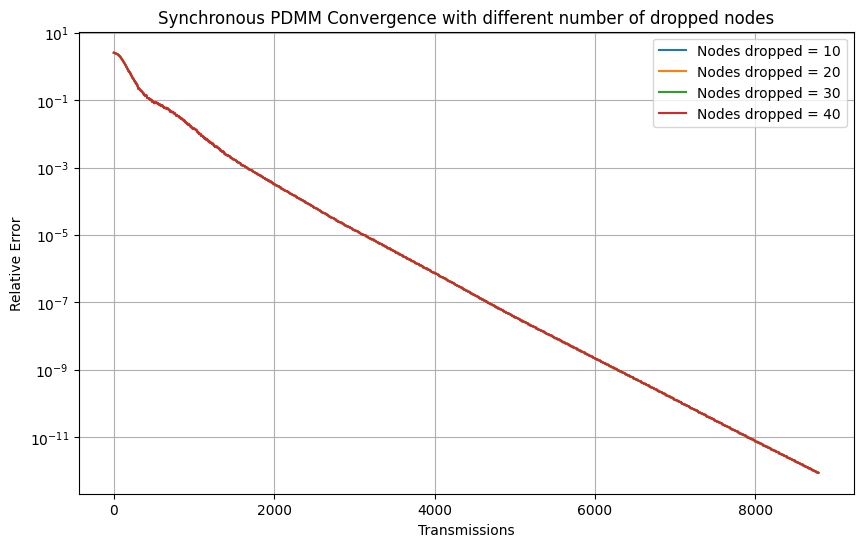

True average: 26.2759
Final average across agents: 26.2759
Min agent value: 26.2759, Max agent value: 26.2759
Final relative error: 8.7733e-13


In [3]:
# PDMM parameters
max_transmissions = 1e6             # Max PDMM iterations
rho = 0.5                           # Penalty parameter (c)
tolerance = 1e-12                   # Convergence tolerance
sensor_values = np.random.randn(n) * 10 + 25


nodes = [10,20,30,40]
plt.figure(figsize=(10, 6))
for i in range(len(nodes)):
    errors, values, n_transmissions = pdmm_sync_drop(sensor_values, adjacency_matrix, rho, max_transmissions, tolerance,transmission_loss_rate=0.0, num_drop= nodes[i])
    plt.semilogy(range(len(errors)), errors, label=f"Nodes dropped = {nodes[i]}")

plt.xlabel('Transmissions')
plt.ylabel('Relative Error')
plt.title(f'Synchronous PDMM Convergence with different number of dropped nodes')
plt.grid(True)
plt.legend()
plt.show()
print(f"True average: {np.mean(sensor_values):.4f}")
print(f"Final average across agents: {np.mean(values):.4f}")
print(f"Min agent value: {np.min(values):.4f}, Max agent value: {np.max(values):.4f}")
print(f"Final relative error: {errors[-1]:.4e}")